In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [2]:
#read data, create feature space, split data into popular/unpopular based on the threshold used in the paper
df = pd.read_csv('OnlineNewsPopularity.csv')
X = df.drop(['url', ' timedelta', ' shares'], axis=1)
y = df[' shares']>1400
y = y.replace(True,1)
y = y.replace(False,0)

In [3]:
y.value_counts()

0.0    20082
1.0    19562
Name:  shares, dtype: int64

The y variable is reasonably balanced, so we don't need to pursue balancing/sampling methods

In [4]:
missing = df.isna().sum()
print(missing)

url                              0
 timedelta                       0
 n_tokens_title                  0
 n_tokens_content                0
 n_unique_tokens                 0
                                ..
 title_subjectivity              0
 title_sentiment_polarity        0
 abs_title_subjectivity          0
 abs_title_sentiment_polarity    0
 shares                          0
Length: 61, dtype: int64


The dataframe does not contain blank values, so we don't need to impute data

(array([3.2349e+04, 6.1670e+03, 8.8600e+02, 1.6800e+02, 4.6000e+01,
        1.3000e+01, 4.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00]),
 array([   0. ,  847.4, 1694.8, 2542.2, 3389.6, 4237. , 5084.4, 5931.8,
        6779.2, 7626.6, 8474. ]),
 <a list of 10 Patch objects>)

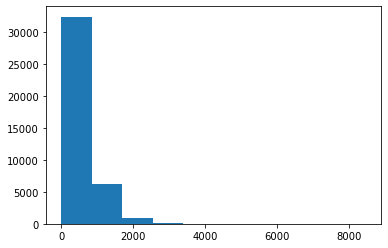

In [5]:
plt.hist(df[' n_tokens_content'])

(array([  51.,   45.,  635., 2427., 4829., 6801., 7322., 6094., 4732.,
        6708.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

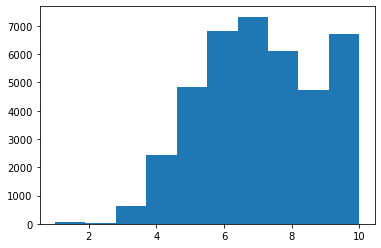

In [6]:
plt.hist(df[' num_keywords'])

A few examples of data being skewed, we therefore decide to apply the yeo johnson transformation (Box Cox requires strictly positive data)

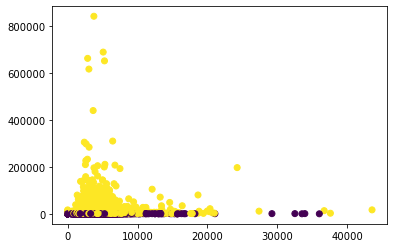

In [7]:
plt.scatter(np.array(X[' kw_avg_avg']), np.array(df[' shares']), c=y)

A few relationships were investigated between the target and the (most important) features, leading to conclude that no clear non-linear relationship was found between those variables. Therefore we decide to not add polynomial features to our model.

In [8]:
#scaler introduced, test/train split made
norm = PowerTransformer(method='yeo-johnson')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, train_size=0.70, test_size = 0.30)

## Logistic Regression

In [9]:
logreg = LogisticRegression(max_iter = 1000)
pipe =  Pipeline(steps=[('YJ', norm), ('logreg', logreg)])
param_grid = {"logreg__C": [ 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(pipe, param_grid = param_grid,return_train_score = True, cv=5)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print('Best C:', grid.best_estimator_.get_params()['logreg__C'])

0.6585945945945946
Best C: 10


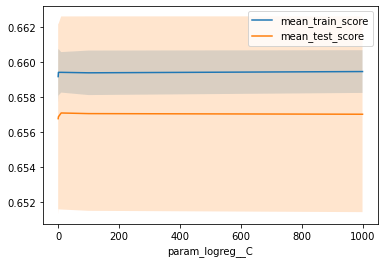

In [10]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_logreg__C', 'mean_train_score')
results.plot('param_logreg__C', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_logreg__C.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_logreg__C.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

We get decent results with Logistic Regression. Scaling of the data really boosts performance for this model.

In [11]:
print(classification_report(y_test, grid.predict(X_test), target_names =['Unpopular','Popular'] ))

              precision    recall  f1-score   support

   Unpopular       0.66      0.67      0.66      6068
     Popular       0.65      0.64      0.64      5826

    accuracy                           0.65     11894
   macro avg       0.65      0.65      0.65     11894
weighted avg       0.65      0.65      0.65     11894



Text(0.5, 1.0, "('Coefficient Magnitude ', 1.0)")

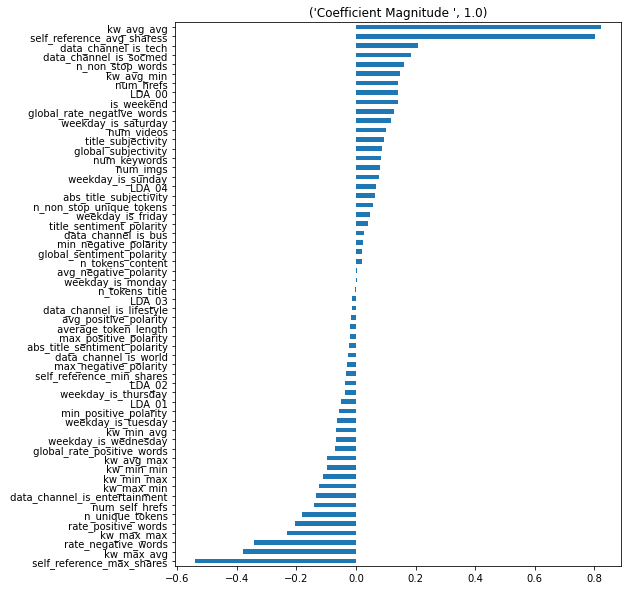

In [12]:
#I re-used this code from our group assignment
#plotting coefficient magnitude
title = "Coefficient Magnitude ", grid.best_estimator_.named_steps['logreg'].classes_[1]
coef = pd.Series(grid.best_estimator_.named_steps['logreg'].coef_[0], index = X.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(title)

kw_avg_avg & self reference_avg_shares seems to have a positive influence on popularity, whereas kw_max_avg & self_reference_max_shares have a strong negative effect


## KNN Classifier

0.6709549549549549
Best n_neighbors: 29


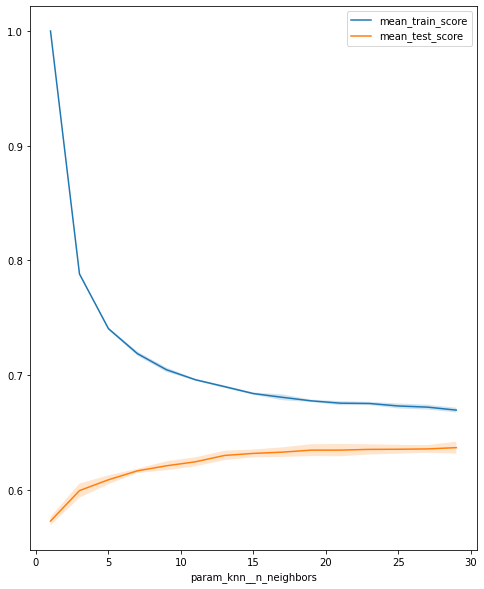

In [13]:
knn = KNeighborsClassifier()
param_grid = {"knn__n_neighbors": range(1,30,2) }
pipe =  Pipeline(steps=[('YJ', norm), ('knn', knn)])
grid = GridSearchCV(pipe, param_grid = param_grid,return_train_score = True, cv=5)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print('Best n_neighbors:', grid.best_estimator_.get_params()['knn__n_neighbors'])

results = pd.DataFrame(grid.cv_results_)
results.plot('param_knn__n_neighbors', 'mean_train_score')
results.plot('param_knn__n_neighbors', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_knn__n_neighbors.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_knn__n_neighbors.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

The KNN classifier performs the worst in terms of accuracy

In [14]:
print(classification_report(y_test, grid.predict(X_test), target_names =['Unpopular','Popular'] ))

              precision    recall  f1-score   support

   Unpopular       0.63      0.69      0.66      6068
     Popular       0.64      0.58      0.61      5826

    accuracy                           0.64     11894
   macro avg       0.64      0.63      0.63     11894
weighted avg       0.64      0.64      0.63     11894



## SVM

C:\Users\simon\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\simon\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\simon\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\simon\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\simon\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

0.6590990990990991
Best C: 0.1


C:\Users\simon\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


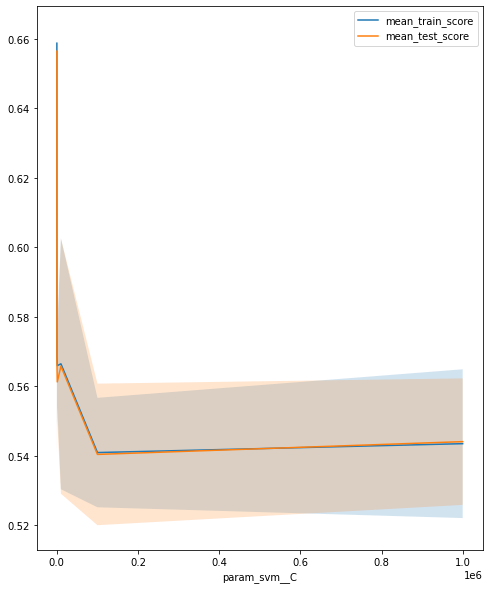

In [15]:
svm = LinearSVC(max_iter=1000)
param_grid = {"svm__C": [ 0.1, 1, 10, 100,1000, 10000, 100000, 1000000] }
pipe =  Pipeline(steps=[('YJ', norm), ('svm', svm)])
grid = GridSearchCV(pipe, param_grid = param_grid,return_train_score = True, cv=5)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print('Best C:', grid.best_estimator_.get_params()['svm__C'])

results = pd.DataFrame(grid.cv_results_)
results.plot('param_svm__C', 'mean_train_score')
results.plot('param_svm__C', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_svm__C.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_svm__C.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()


In [16]:
print(classification_report(y_test, grid.predict(X_test), target_names =['Unpopular','Popular'] ))

              precision    recall  f1-score   support

   Unpopular       0.66      0.67      0.66      6068
     Popular       0.65      0.63      0.64      5826

    accuracy                           0.65     11894
   macro avg       0.65      0.65      0.65     11894
weighted avg       0.65      0.65      0.65     11894



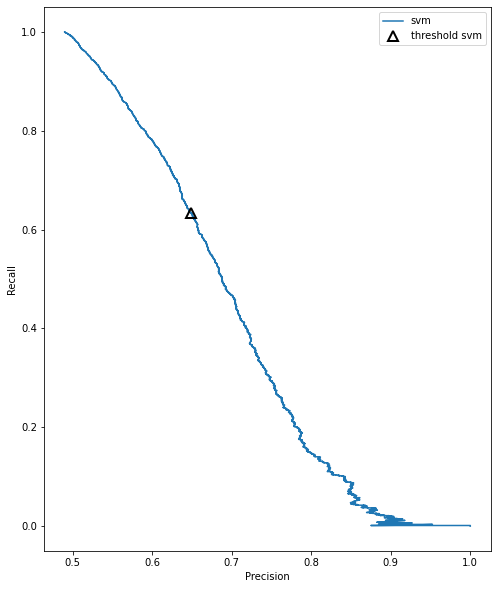

In [17]:
precision_svm, recall_svm, thresholds_svm_auc = precision_recall_curve(
    y_test, grid.decision_function(X_test))

plt.plot(precision_svm, recall_svm, label="svm")
close_default_svm_auc = np.argmin(np.abs(thresholds_svm_auc))
plt.plot(precision_svm[close_default_svm_auc], recall_svm[close_default_svm_auc], '^', c='k',
         markersize=10, label="threshold svm", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

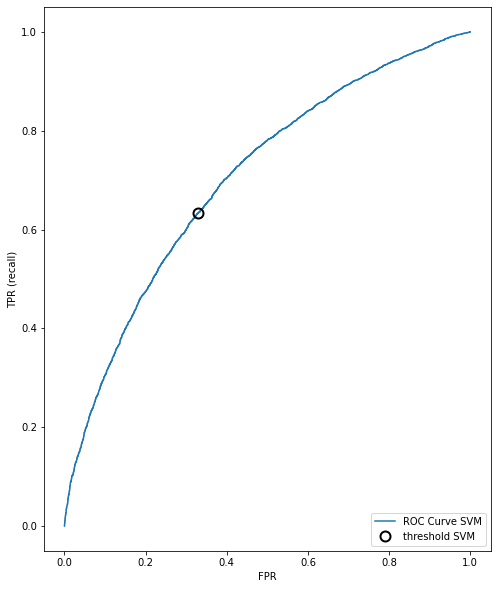

In [19]:
fpr_svm, tpr_svm, thresholds_svm_roc = roc_curve(y_test, grid.decision_function(X_test))
plt.plot(fpr_svm, tpr_svm, label="ROC Curve SVM")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_default_svm = np.argmin(np.abs(thresholds_svm_roc))
plt.plot(fpr_svm[close_default_svm], tpr_svm[close_default_svm], 'o', markersize=10,
         label="threshold SVM", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

## RandomForest

0.8498738738738739
best mean cross-validation score: 0.664
Best max_depth: 12


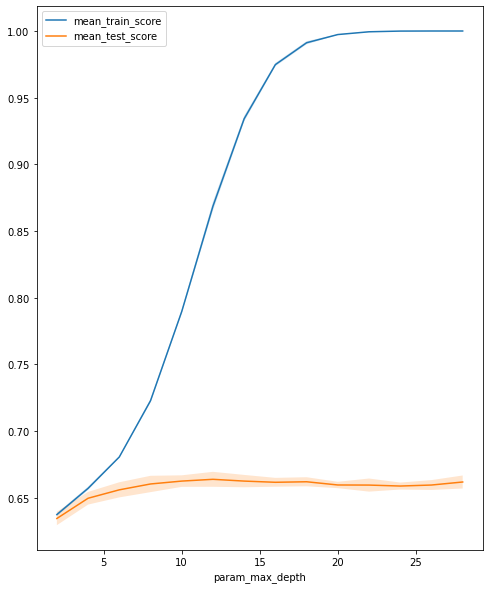

In [20]:
rf = RandomForestClassifier(warm_start=True, random_state=42)
param_grid = {'max_depth': range(2,30,2)}
grid = GridSearchCV(rf, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=2)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best max_depth:', grid.best_estimator_.get_params()['max_depth'])

results = pd.DataFrame(grid.cv_results_)
results.plot('param_max_depth', 'mean_train_score')
results.plot('param_max_depth', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_max_depth.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_max_depth.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

0.8516036036036037
best mean cross-validation score: 0.664
Best max_features: 8


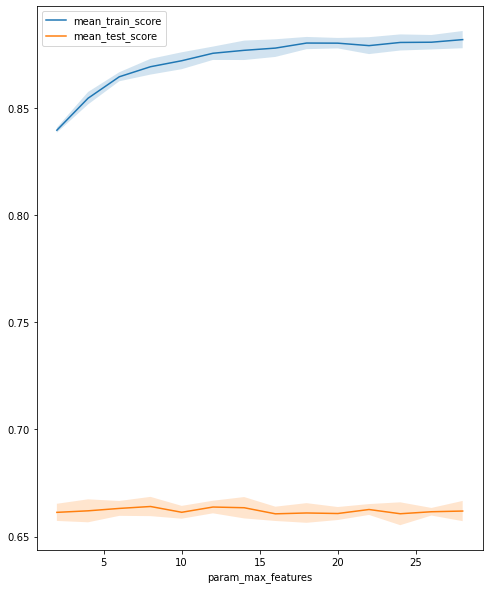

In [21]:
# parameter max_depth = 12 was found in the previous tuning excersise and will be used to tune the most important RF-param
rf = RandomForestClassifier(warm_start=True, max_depth =12, random_state=42)
param_grid = {'max_features': range(2,30,2)} 
grid = GridSearchCV(rf, param_grid = param_grid  ,return_train_score = True, cv=5, n_jobs=2)
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print('Best max_features:', grid.best_estimator_.get_params()['max_features'])

results = pd.DataFrame(grid.cv_results_)
results.plot('param_max_features', 'mean_train_score')
results.plot('param_max_features', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_max_features.astype(float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_max_features.astype(float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

In [22]:
print(classification_report(y_test, grid.predict(X_test) , target_names =['Unpopular','Popular'])) 

              precision    recall  f1-score   support

   Unpopular       0.67      0.66      0.67      6068
     Popular       0.65      0.66      0.65      5826

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



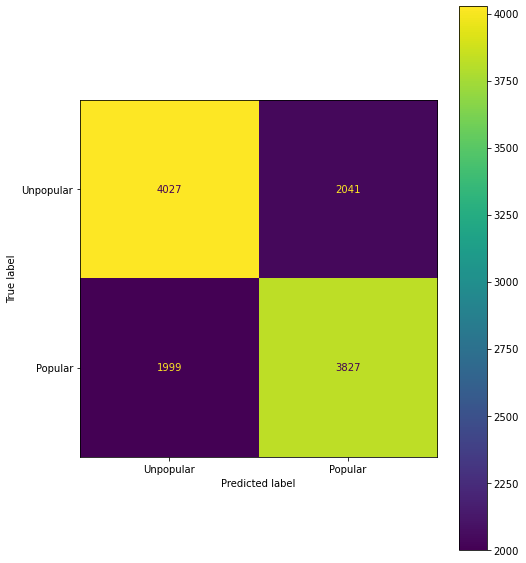

In [23]:
plot_confusion_matrix(grid, X_test, y_test , display_labels=['Unpopular','Popular'])

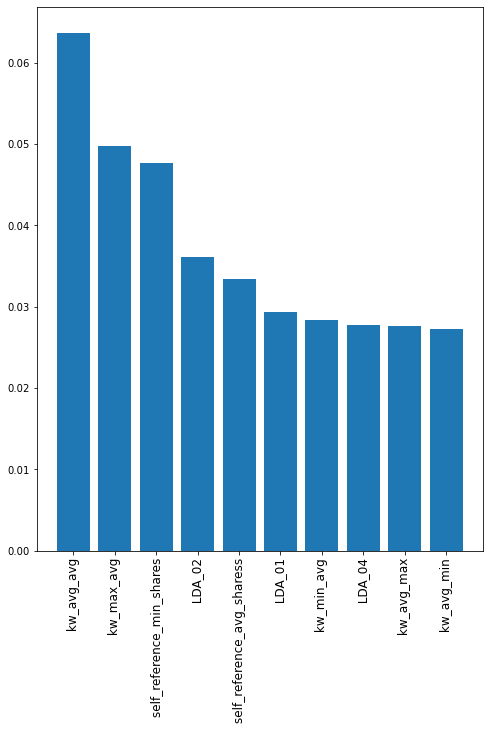

In [24]:
feature_imp = grid.best_estimator_.feature_importances_
df2 = pd.DataFrame(feature_imp,X_train.columns,["feature_importance"])
df2 = df2.sort_values(by="feature_importance" , ascending=False)
df2 = df2[:10]
plt.bar(df2.index, df2.feature_importance, orientation = 'vertical')
plt.tick_params(axis="x", labelsize=12, labelrotation=90)
plt.show()

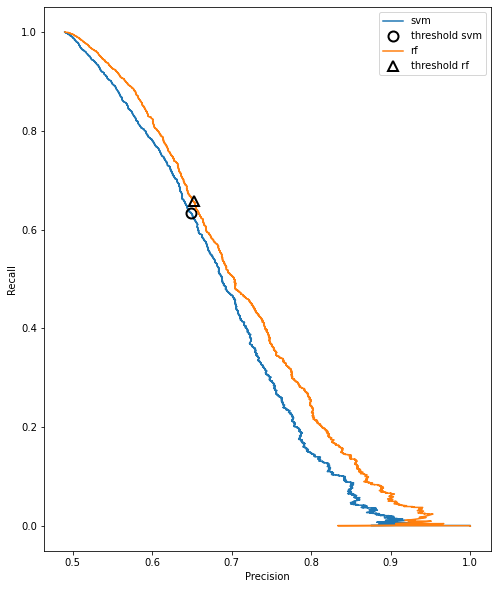

In [25]:


precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, grid.predict_proba(X_test)[:, 1])

plt.plot(precision_svm, recall_svm, label="svm")
plt.plot(precision_svm[close_default_svm_auc], recall_svm[close_default_svm_auc], 'o', c='k',
         markersize=10, label="threshold svm", fillstyle="none", mew=2)

plt.plot(precision_rf, recall_rf, label="rf")
close_default_rf = np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

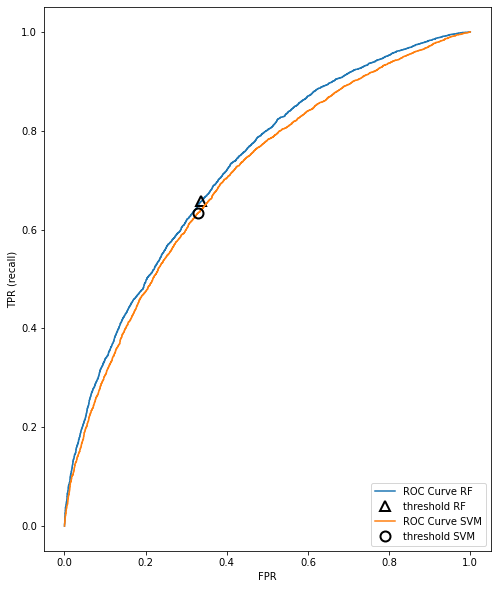

In [27]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, grid.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="threshold RF", fillstyle="none", c='k', mew=2)

plt.plot(fpr_svm, tpr_svm, label="ROC Curve SVM")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_default_svm = np.argmin(np.abs(thresholds_svm_roc))
plt.plot(fpr_svm[close_default_svm], tpr_svm[close_default_svm], 'o', markersize=10,
         label="threshold SVM", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)


Text(0, 0.5, 'accuracy')

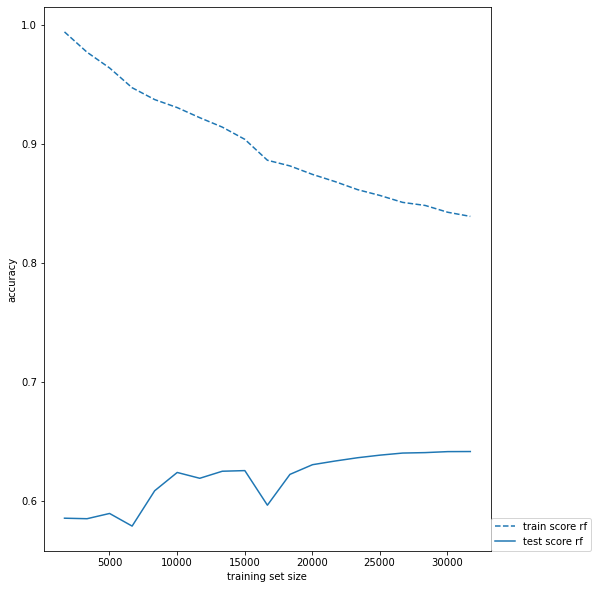

In [28]:
def plot_learning_curve(est, name):
    train_set_size, train_scores, test_scores = learning_curve(est, X, y, cv=5, train_sizes=np.linspace(0, 1, 20)[1:])
    test_mean = test_scores.mean(axis=1)
    train_mean = train_scores.mean(axis=1)
    line, = plt.plot(train_set_size, train_mean, linestyle="--", label="train score {}".format(name))
    plt.plot(train_set_size, test_mean, label="test score {}".format(name),
             c=line.get_color())
    
plot_learning_curve(RandomForestClassifier(warm_start=True, random_state=42, max_depth=12), "rf")
plt.legend(loc=(1, 0))
plt.xlabel("training set size")
plt.ylabel("accuracy")

Plotting the learning curve for the RF model